# **EXPLORE WEATHER TRENDS**

**_1. The SQL query used for extracting the data from the database:_**

In [1]:
#SQL query the data for global temperature
"""SELECT *
    FROM global_data"""

#SQL query the data for Vietnam temperature
"""SELECT * 
    FROM city_data
    WHERE country = 'Vietnam';"""

"SELECT * \n    FROM city_data\n    WHERE country = 'Vietnam';"

**_2. Import the data from the source data queries from the database for analysis._**

In [2]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Import csv file into Python and seperate two cities Hanoi and Ho Chi Minh city from the total data set viet_temp
glob_temp = pd.read_csv("Global_temp.csv")
viet_temp = pd.read_csv("Vietnam_temp.csv")
hanoi = viet_temp[viet_temp['city'] == 'Hanoi']
hcm = viet_temp[viet_temp['city'] == 'Ho Chi Minh City']

In [4]:
#Check the data quality of glob_temp
glob_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      266 non-null    int64  
 1   avg_temp  266 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.3 KB


In [5]:
#Check the data quality of hcm
hcm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 174 to 362
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      189 non-null    int64  
 1   city      189 non-null    object 
 2   country   189 non-null    object 
 3   avg_temp  174 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.4+ KB


In [6]:
#Check the data quality of hanoi
hanoi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      174 non-null    int64  
 1   city      174 non-null    object 
 2   country   174 non-null    object 
 3   avg_temp  174 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.8+ KB


**_3. Check any outliers within the data of each data set and get them ready for analysis, including:_**
- Remove all rows till the last year having null value to ensure the data continuty

In [7]:
#Remove all the row from the first to the last null value in the dataset hcm
max_year_have_null = hcm.loc[hcm['avg_temp'].isnull(),'year'].max()
hcm = hcm[hcm['year'] > max_year_have_null]

**_4. Create the moving average for global, HCM and Hanoi and join all three tables into one_**

In [8]:
#create a function to create moving average column and settle redundant information or inappropriate information in the dataframe
def moving_average(df,name,period = 1,remove = True):
    avg_name = 'avg_temp_{}'.format(name)
    col_name = 'SMA_{}_{}'.format(period,name)
    df[col_name] = df.loc[:,'avg_temp'].rolling(window = period).mean()
    if remove:
        df = df.rename(columns = {'avg_temp':avg_name}, inplace = False).drop(['city','country'], axis = 1)
    else:
        df = df.rename(columns = {'avg_temp':avg_name}, inplace = False)
    return df

In [9]:
#Calculate the moving average under period of 5 years for each location
hcm_sma = moving_average(hcm,name = "HCM",period = 5)
hanoi_sma = moving_average(hanoi,name = "Hanoi", period = 5)
global_sma = moving_average(glob_temp,name = "global",period = 5, remove = False)

#Calculate the moving average under period of 10 years for Hanoi
hcm_sma = moving_average(hcm,name = "HCM",period = 10)
hanoi_sma = moving_average(hanoi,name = "Hanoi", period = 10)
global_sma = moving_average(glob_temp,name = "global",period = 10, remove = False)

<ipython-input-8-2468eba495c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df.loc[:,'avg_temp'].rolling(window = period).mean()


In [10]:
#Join 3 tables into 1 table for analysis under the condition of year
project_temp = global_sma.set_index('year').join(hcm_sma.set_index('year'), how = 'inner',lsuffix = '_global',rsuffix = '_HCM')
project_temp = project_temp.join(hanoi_sma.set_index('year'), how = 'inner',rsuffix = '_Hanoi')

**_5. Descriptive analysis_**

In [11]:
project_temp[['avg_temp_global','avg_temp_HCM','avg_temp_Hanoi']].describe()

,avg_temp_global,avg_temp_HCM,avg_temp_Hanoi
count,164.000000,164.000000,164.000000
mean,8.558049,27.213354,21.591280
std,0.459362,0.492062,0.476454
min,7.560000,24.850000,20.480000
25%,8.190000,26.870000,21.267500
50%,8.535000,27.265000,21.545000
75%,8.770000,27.552500,21.912500
max,9.730000,28.460000,23.100000


In [12]:
#create the analysis_df dataframe for analysis
analysis_df = project_temp[['avg_temp_global','avg_temp_HCM','avg_temp_Hanoi']].describe().transpose()[['mean','std','min','max']]
analysis_df['variance'] = analysis_df['max'] - analysis_df['min']
analysis_df['% variance'] = analysis_df['variance'] / analysis_df['min'] * 100
analysis_df['variance per year'] = analysis_df['variance'] / analysis_df.count(axis = 0)[0]

analysis_df

,mean,std,min,max,variance,% variance,variance per year
avg_temp_global,8.558049,0.459362,7.56,9.73,2.17,28.703704,0.723333
avg_temp_HCM,27.213354,0.492062,24.85,28.46,3.61,14.527163,1.203333
avg_temp_Hanoi,21.591280,0.476454,20.48,23.10,2.62,12.792969,0.873333


**_Initial analysis_**

1. In the general view, the temperature of three location overally increased throughout 164 years, in which the temperature of Ho Chi Minh city has the highest increase with 3.61 celcius compared to the lower 2.62 and 2.17 celcius of Hanoi and global area, respectively.

2. However, even when the global temperature is the area having the lowest increase, with only 2.17 Celsius in absolute, the speed of the increase in temperature for the global area is recorded as the highest, while, during 164 years, the temperature increased by up to 28.7%, which is double the speed of increase for Ho Chi Minh City and Hanoi.

3. The standard deviation for the temperature shows that the temperature in Ho Chi Minh City has experienced more volatile than the other two with the highest 0.49. Meanwhile, the global temperature seems like the most stable among three areas.

In [13]:
#Calculate the Correlation Coefficient between average temperature of global with the average temperature of Ho Chi Minh City and Hanoi
corr_temp = project_temp[['avg_temp_global','avg_temp_HCM','avg_temp_Hanoi']].corr()
corr_temp

,avg_temp_global,avg_temp_HCM,avg_temp_Hanoi
avg_temp_global,1.000000,0.841227,0.716696
avg_temp_HCM,0.841227,1.000000,0.810685
avg_temp_Hanoi,0.716696,0.810685,1.000000


**_Correlation Coefficient_**

To set the variance of global temperature as a standard, it could be seen that the temperature in Ho Chi Minh City has a stronger correlation with the global than in Hanoi when the correlation index with the global of Ho Chi Minh City is 0.84 compared to 0.71 of Hanoi. 

**_6. Data visualization_**
- Visualize the moving average under two period:

    + period of 5 years
    + period of 10 years

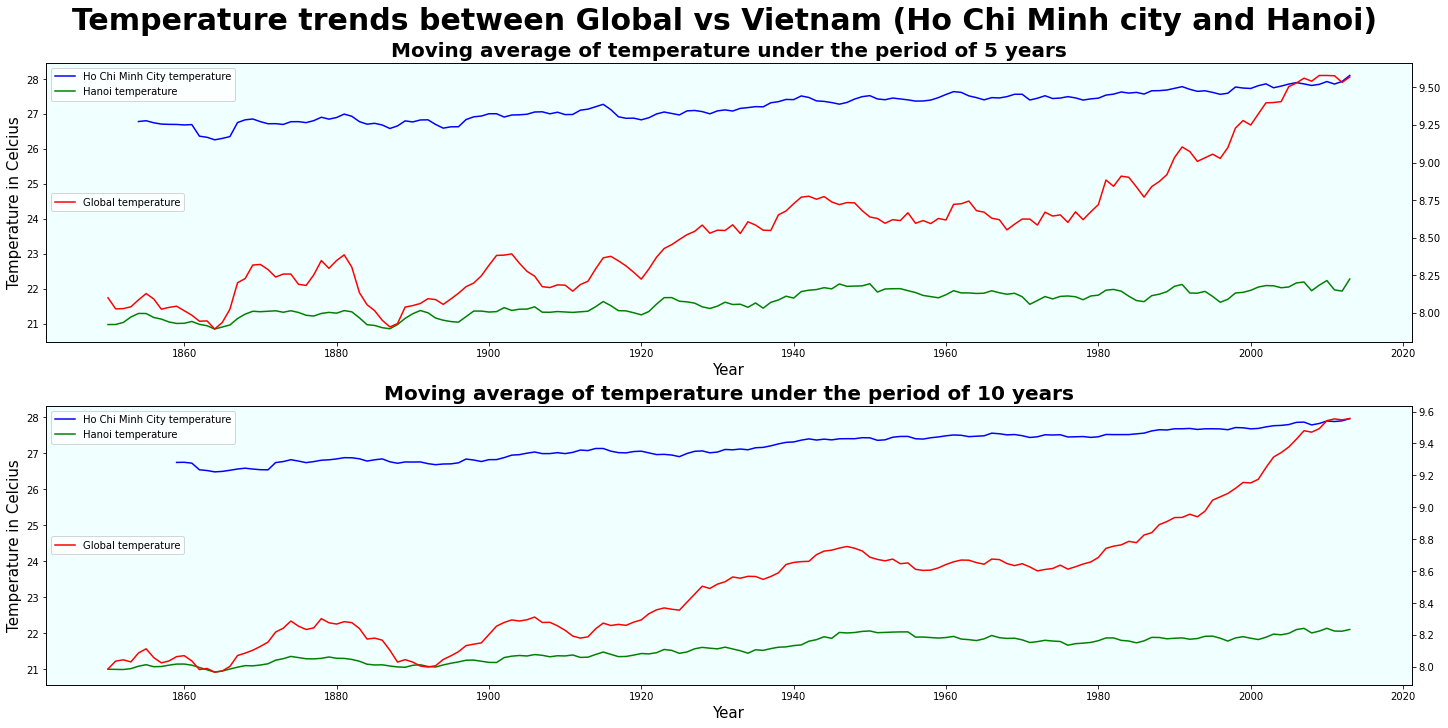

In [14]:
#Visualize the moving average under the period of 5 years
sma_5 = project_temp[['SMA_5_global','SMA_5_HCM','SMA_5_Hanoi']]

fig, (ax1, ax2)  = plt.subplots(2,1,figsize = [20,10],constrained_layout=True)
fig.suptitle('Temperature trends between Global vs Vietnam (Ho Chi Minh city and Hanoi)',
             fontsize = 30, 
             weight = 'extra bold')

ax_glob = ax1.twinx()
ax_glob.plot(sma_5["SMA_5_global"],'-r', label = "Global temperature")
ax1.plot(sma_5['SMA_5_HCM'], '-b', label = 'Ho Chi Minh City temperature')
ax1.plot(sma_5['SMA_5_Hanoi'], '-g', label = "Hanoi temperature")

ax1.set_title('Moving average of temperature under the period of 5 years', fontsize = 20, weight = 'bold')
ax1.set_xlabel('Year', fontsize = 15)
ax1.set_ylabel('Temperature in Celcius', fontsize  = 15)
ax1.legend()
ax_glob.legend(loc = 6)
ax1.set_facecolor ('#F0FFFF')

#Visualize the moving average under the period of 10 years
sma_10 = project_temp[['SMA_10_global','SMA_10_HCM','SMA_10_Hanoi']]

ax_glob_10 = ax2.twinx()
ax_glob_10.plot(sma_10["SMA_10_global"],'-r', label = "Global temperature")
ax2.plot(sma_10['SMA_10_HCM'], '-b', label = 'Ho Chi Minh City temperature')
ax2.plot(sma_10['SMA_10_Hanoi'], '-g', label = "Hanoi temperature")

ax2.set_title('Moving average of temperature under the period of 10 years', fontsize = 20, weight = 'bold')
ax2.set_xlabel('Year', fontsize = 15)
ax2.set_ylabel('Temperature in Celcius', fontsize  = 15)
ax2.legend()
ax_glob_10.legend(loc = 6)
ax2.set_facecolor ('#F0FFFF')


plt.show()


**_Final analysis based on the Temperature trend_**

1. According to the chart above, among the 3 areas, Ho Chi Minh City has the highest temperature with 27.2 degC on average and 28.46 degC on maximum. Following is Hanoi as a second high of which the average temperature is 21.6 degC while the overall temperature of the global is recorded at 8.6 degC. This is due to that Vietnam is located close to the equator, especially Ho Chi Minh City, while the index recorded under global temperature covers every location over the globe.


2. As shown in the chart, it could be seen that the temperature of all three areas has increased in overall for the period of 164 years:
 - According to the moving average chart for the global temperature, before 1980 is a slight increase, however, after 1980, it shows a steep surge which may indicate that the temperature changed rapidly during this period.
 - Unlike the global temperature, the moving average chart of Ho Chi Minh City and Hanoi illustrate the gradual increase throughout the review period.


3. According to the SMA_5 line chart, the global temperature had frequent fluctuations and the volatility was also relatively higher than other regions. Meanwhile, the temperature of Ho Chi Minh City and Hanoi under the SMA_5 shows the less fluctuation however, according to the standard deviation of these two areas aforementioned, it is shown the facts that Ho Chi Minh City had the highest volatility, following is Hanoi and the last was global temperature.